# Brain Hemorrhage Detection

### Imports

In [25]:
import boto3
import re
import time
from IPython.display import Image
from sagemaker import get_execution_role
from time import gmtime, strftime

### Setting Configurations

In [26]:
bucket = 'brain-hemorrhage-data-moment'

role = get_execution_role()

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}

training_image = containers[boto3.Session().region_name]

# Training the Image Classification Model

## Training parameters

In [3]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
num_layers = 18
# We need to specify the input image shape for the training data
image_shape = "3,512,512"
# We also need to specify the number of training samples in the training set
num_training_samples = 83783
# Specify the number of output classes
num_classes = 3
# Batch size for training
mini_batch_size =  100
# Number of epochs
epochs = 5
# Learning rate
learning_rate = 0.001
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

## Training

In [4]:
%time
s3 = boto3.client('s3')

# create unique job name 
job_name_prefix = 'brain-model'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.2xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/Brain/train'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/Brain/validation'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs
Training job name: brain-model-2020-06-16-11-34-23

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://brain-hemorrhage-data-moment/Brain/train', 'S3DataDistributionType': 'FullyReplicated'}


## Initializing Training

In [5]:
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [6]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


# Create Model


In [7]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="image-classification-brainep-transfer"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

image-classification-brainep-transfer
s3://brain-hemorrhage-data-moment/brain-model/brain-model-2020-06-16-11-34-23/output/model.tar.gz
arn:aws:sagemaker:us-east-1:649293849303:model/image-classification-brainep-transfer
CPU times: user 65.3 ms, sys: 12.2 ms, total: 77.5 ms
Wall time: 534 ms


## Create Endpoint Configuration

In [19]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.p3.2xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: brain-model-epc--2020-06-16-14-46-12
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:649293849303:endpoint-config/brain-model-epc--2020-06-16-14-46-12


## Create Endpoint

In [20]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: brain-model-ep--2020-06-16-14-46-14
EndpointArn = arn:aws:sagemaker:us-east-1:649293849303:endpoint/brain-model-ep--2020-06-16-14-46-14
CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 251 ms


Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [21]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


Maximum validation accuracy: 0.590000 


<Figure size 432x288 with 0 Axes>

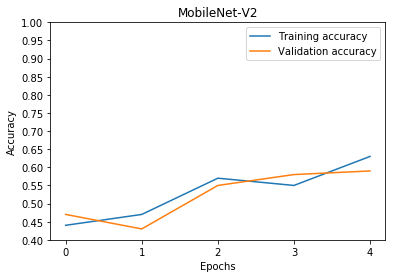

In [58]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

client = boto3.client('logs')

lgn='/aws/sagemaker/TrainingJobs'

job_name = 'brain-model-2020-06-16-11-34-23'

# # Update this with the actual name in CloudWatch logs
lsn=job_name+'/'+'algo-1-1592307407'
log=client.get_log_events(logGroupName=lgn, logStreamName=lsn)

trn_accs=[]
val_accs=[]
for e in log['events']:
    msg=e['message']
    if 'Validation-accuracy' in msg:
        val = msg.split("=")
        val = val[1]
        val_accs.append(float(val))
    if 'Train-accuracy' in msg:
        trn = msg.split("=")
        trn = trn[1]
        trn_accs.append(float(trn))
trn_accs = [0.44,0.47,0.57,0.55,0.63]
val_accs = [0.47,0.43,0.55,0.58,0.59]

print("Maximum validation accuracy: %f " % max(val_accs))
plt.clf()
fig, ax = plt.subplots()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet-V2')
trn_plot, = ax.plot(range(epochs), trn_accs, label="Training accuracy")
val_plot, = ax.plot(range(epochs), val_accs, label="Validation accuracy")
plt.legend(handles=[trn_plot,val_plot])
plt.xticks(range(0, 5))

ax.yaxis.set_ticks(np.arange(0.4, 1.05, 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()

# Perform Inference

In [22]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

## Download test image

--2020-06-16 14:54:56--  https://res.cloudinary.com/itu/image/upload/v1592184341/100055CT000270_wuhm1w.png
Resolving res.cloudinary.com (res.cloudinary.com)... 151.101.249.137, 2a04:4e42:3b::393
Connecting to res.cloudinary.com (res.cloudinary.com)|151.101.249.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78209 (76K) [image/png]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  76.38K  --.-KB/s    in 0.002s  

2020-06-16 14:54:56 (32.5 MB/s) - ‘/tmp/test.jpg’ saved [78209/78209]



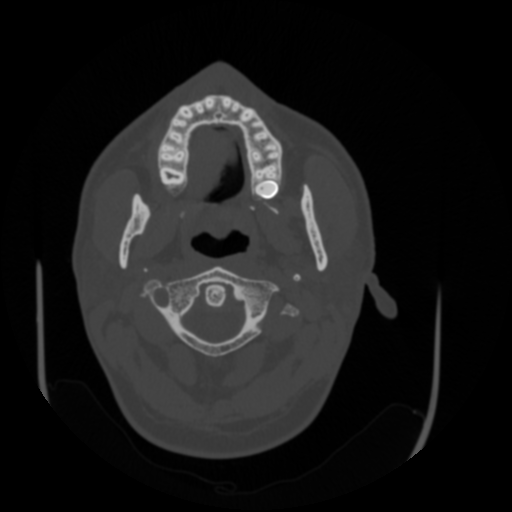

In [23]:
# Example Image
!wget -O /tmp/test.jpg https://res.cloudinary.com/itu/image/upload/v1592184341/100055CT000270_wuhm1w.png
file_name = '/tmp/test.jpg'
Image(file_name)

In [24]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
print(index)
object_categories = ['Intracranial', 'Mass Effect', 'Midline Shift']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

[0.03312947228550911, 0.853060245513916, 0.11381025612354279]
1
Result: label - Mass Effect, probability - 0.853060245513916


### Delete Endpoint (in case it is not in use)

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)